# ResNet for cifar10

- visdom 과정을 생략하는 대신 loss plot을 수행할 수 있도록 코드 수정함

In [64]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [65]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
    
print(device)

cuda


### 데이터셋 생성

In [81]:
# 이미지 데이터셋 정규화 이전, 평균과 표준편차 구하기
transform = transforms.Compose([
    transforms.ToTensor()
])

train = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)

print(trainset.data.shape)

train_data_mean = train.data.mean( axis=(0,1,2) ) # 평균
train_data_std = train.data.std( axis=(0,1,2) ) # 표준편차


print(train_data_mean)
print(train_data_std)

train_data_mean = train_data_mean / 255
train_data_std = train_data_std / 255

print(train_data_mean)
print(train_data_std)

Files already downloaded and verified
(10000, 32, 32, 3)
[125.30691805 122.95039414 113.86538318]
[62.99321928 62.08870764 66.70489964]
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [82]:
# 이미지 정규화 수행
# 정규화 할 것들 선언
trans_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)
])

trans_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)
])

# 정규화 적용
# 학습용
trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=trans_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=0)

# 훈련용
testset = datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=trans_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [83]:
len(trainloader)

40

In [84]:
len(testloader)

40

In [85]:
# 이미지 한 개 정보 출력
for i,l in trainloader:
    print(i.shape)
    break

torch.Size([256, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


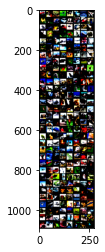

  car   dog  frog  bird


In [86]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# 정규화된 이미지 출력 함수
def imshow(img):
    npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# 이미지 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 출력
imshow(torchvision.utils.make_grid(images))


# label 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### resnet 생성 및 준비

In [87]:
import torchvision.models.resnet as resnet

conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [88]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 128, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
                    
                    

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [89]:
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 10, True).to(device) 
summary(resnet50,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]             256
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]           1,024
      BatchNorm2d-11           [-1, 64, 32, 32]             128
           Conv2d-12           [-1, 64, 32, 32]           1,024
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [90]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(resnet50.parameters(), lr = 0.1, momentum = 0.9, weight_decay=5e-4)
lr_sche = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [91]:
trainloader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar10
    Split: Test
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )

In [92]:
testloader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar10
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )

### 학습 및 평가

In [97]:
# 모델 저장 및 평가하는 함수 정의
test_accuracy_list = []

def acc_check(net, test_set, epoch, save=1):
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, label in test_set:
            images = images.to(device)
            label = label.to(device)
            
            out = net(images)
            
            prediction = out.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    acc = 100. * correct / len(testloader.dataset)
    test_accuracy_list.append(acc)        
    if save:
        torch.save(net.state_dict(), "./model/model_epoch_{}_acc_{}.pth".format(epoch, int(acc)))
        
    return acc

In [99]:
# 학습 후 모델 평가 수행
epochs = 50
train_loss_batch = []
train_loss_all = []
num_of_mini_batch = len(trainloader)

for epoch in range(epochs):
    avg_cost = 0
    print("================= EPOCH {} =================".format(epoch+1))      
    lr_sche.step()
    
    for idx, (img, label) in enumerate(trainloader):
        img = img.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        
        outs = resnet50(img)
        loss = criterion(outs, label)
        loss.backward()
        optimizer.step()
        
        train_loss_batch.append(loss)
        avg_cost = avg_cost + (loss.item()/num_of_mini_batch)
        
        # 로그 출력. 한 에폭당 10개의 배치묶음마다 로그 출력. 총 256개의 배치묶음 존재
        if (idx % 10 == 0) :
            print("[{}/{}] Train Loss : {:.6f} ".format(idx*256,len(trainloader.dataset),loss.item()))
        
    train_loss_all.append(avg_cost)
        
    # 평가
    acc = acc_check(resnet50, testloader, epoch, save=1)
    print("test data 예측 성능 : {:.2f}%".format(acc))
    
print('Finished')

================= EPOCH 1 =================
[0/10000] Train Loss : 1.834876 
[2560/10000] Train Loss : 1.791981 
[5120/10000] Train Loss : 1.706997 
[7680/10000] Train Loss : 1.643994 
test data 예측 성능 : 34.97000%
================= EPOCH 2 =================
[0/10000] Train Loss : 1.705883 
[2560/10000] Train Loss : 1.588341 
[5120/10000] Train Loss : 1.668432 
[7680/10000] Train Loss : 1.735654 
test data 예측 성능 : 35.12000%
================= EPOCH 3 =================
[0/10000] Train Loss : 1.622481 
[2560/10000] Train Loss : 1.582722 
[5120/10000] Train Loss : 1.556857 
[7680/10000] Train Loss : 1.534608 
test data 예측 성능 : 40.88000%
================= EPOCH 4 =================
[0/10000] Train Loss : 1.537222 
[2560/10000] Train Loss : 1.497276 
[5120/10000] Train Loss : 1.546713 
[7680/10000] Train Loss : 1.473413 
test data 예측 성능 : 44.37000%
================= EPOCH 5 =================
[0/10000] Train Loss : 1.405477 
[2560/10000] Train Loss : 1.513365 
[5120/10000] Train Loss : 1.415396 

[2560/10000] Train Loss : 0.411900 
[5120/10000] Train Loss : 0.486869 
[7680/10000] Train Loss : 0.424451 
test data 예측 성능 : 73.19000%
================= EPOCH 40 =================
[0/10000] Train Loss : 0.417302 
[2560/10000] Train Loss : 0.450144 
[5120/10000] Train Loss : 0.397884 
[7680/10000] Train Loss : 0.391646 
test data 예측 성능 : 73.21000%
================= EPOCH 41 =================
[0/10000] Train Loss : 0.383568 
[2560/10000] Train Loss : 0.492103 
[5120/10000] Train Loss : 0.530821 
[7680/10000] Train Loss : 0.467184 
test data 예측 성능 : 73.55000%
================= EPOCH 42 =================
[0/10000] Train Loss : 0.343765 
[2560/10000] Train Loss : 0.442089 
[5120/10000] Train Loss : 0.444377 
[7680/10000] Train Loss : 0.359392 
test data 예측 성능 : 73.43000%
================= EPOCH 43 =================
[0/10000] Train Loss : 0.458152 
[2560/10000] Train Loss : 0.359271 
[5120/10000] Train Loss : 0.413193 
[7680/10000] Train Loss : 0.381633 
test data 예측 성능 : 75.23000%
========

#### plotting

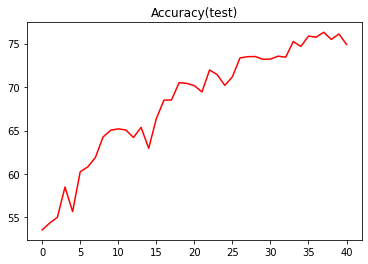

In [100]:
plt.title('Accuracy(test)')
plt.plot(np.array(test_accuracy_list[10:]), 'r')

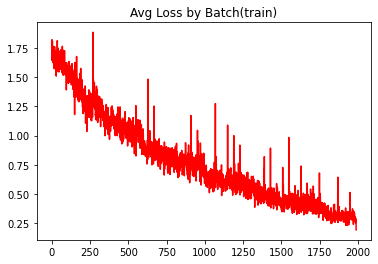

In [102]:
plt.title('Avg Loss by Batch(train)')
plt.plot(np.array(train_loss_batch[10:]), 'r')